In [4]:
import pandas as pd
import yaml
root_path = '/local/work/merengelke/aipal/'
config = yaml.load(open('cfg.yaml', 'r'), Loader=yaml.FullLoader)

cities_countries = config['cities_countries']
paths = [f"{root_path}{city_country}/aipal/predict.csv" for city_country in cities_countries]

df = pd.DataFrame()
for path in paths:
    df_small = pd.read_csv(path)
    df_small['city_country'] = path.split('/')[-3]
    df = pd.concat([df, df_small])
    
# age over 18
if config['is_adult']:
    df = df[df['age'] > 18]
else:
    df = df[df['age'] <= 18]
df.drop(columns=['ELN', 'Diagnosis', 'additional.diagnosis.details..lineage.etc', 'lineage.details'], inplace=True)
df['class'] = df['class'].str.strip()

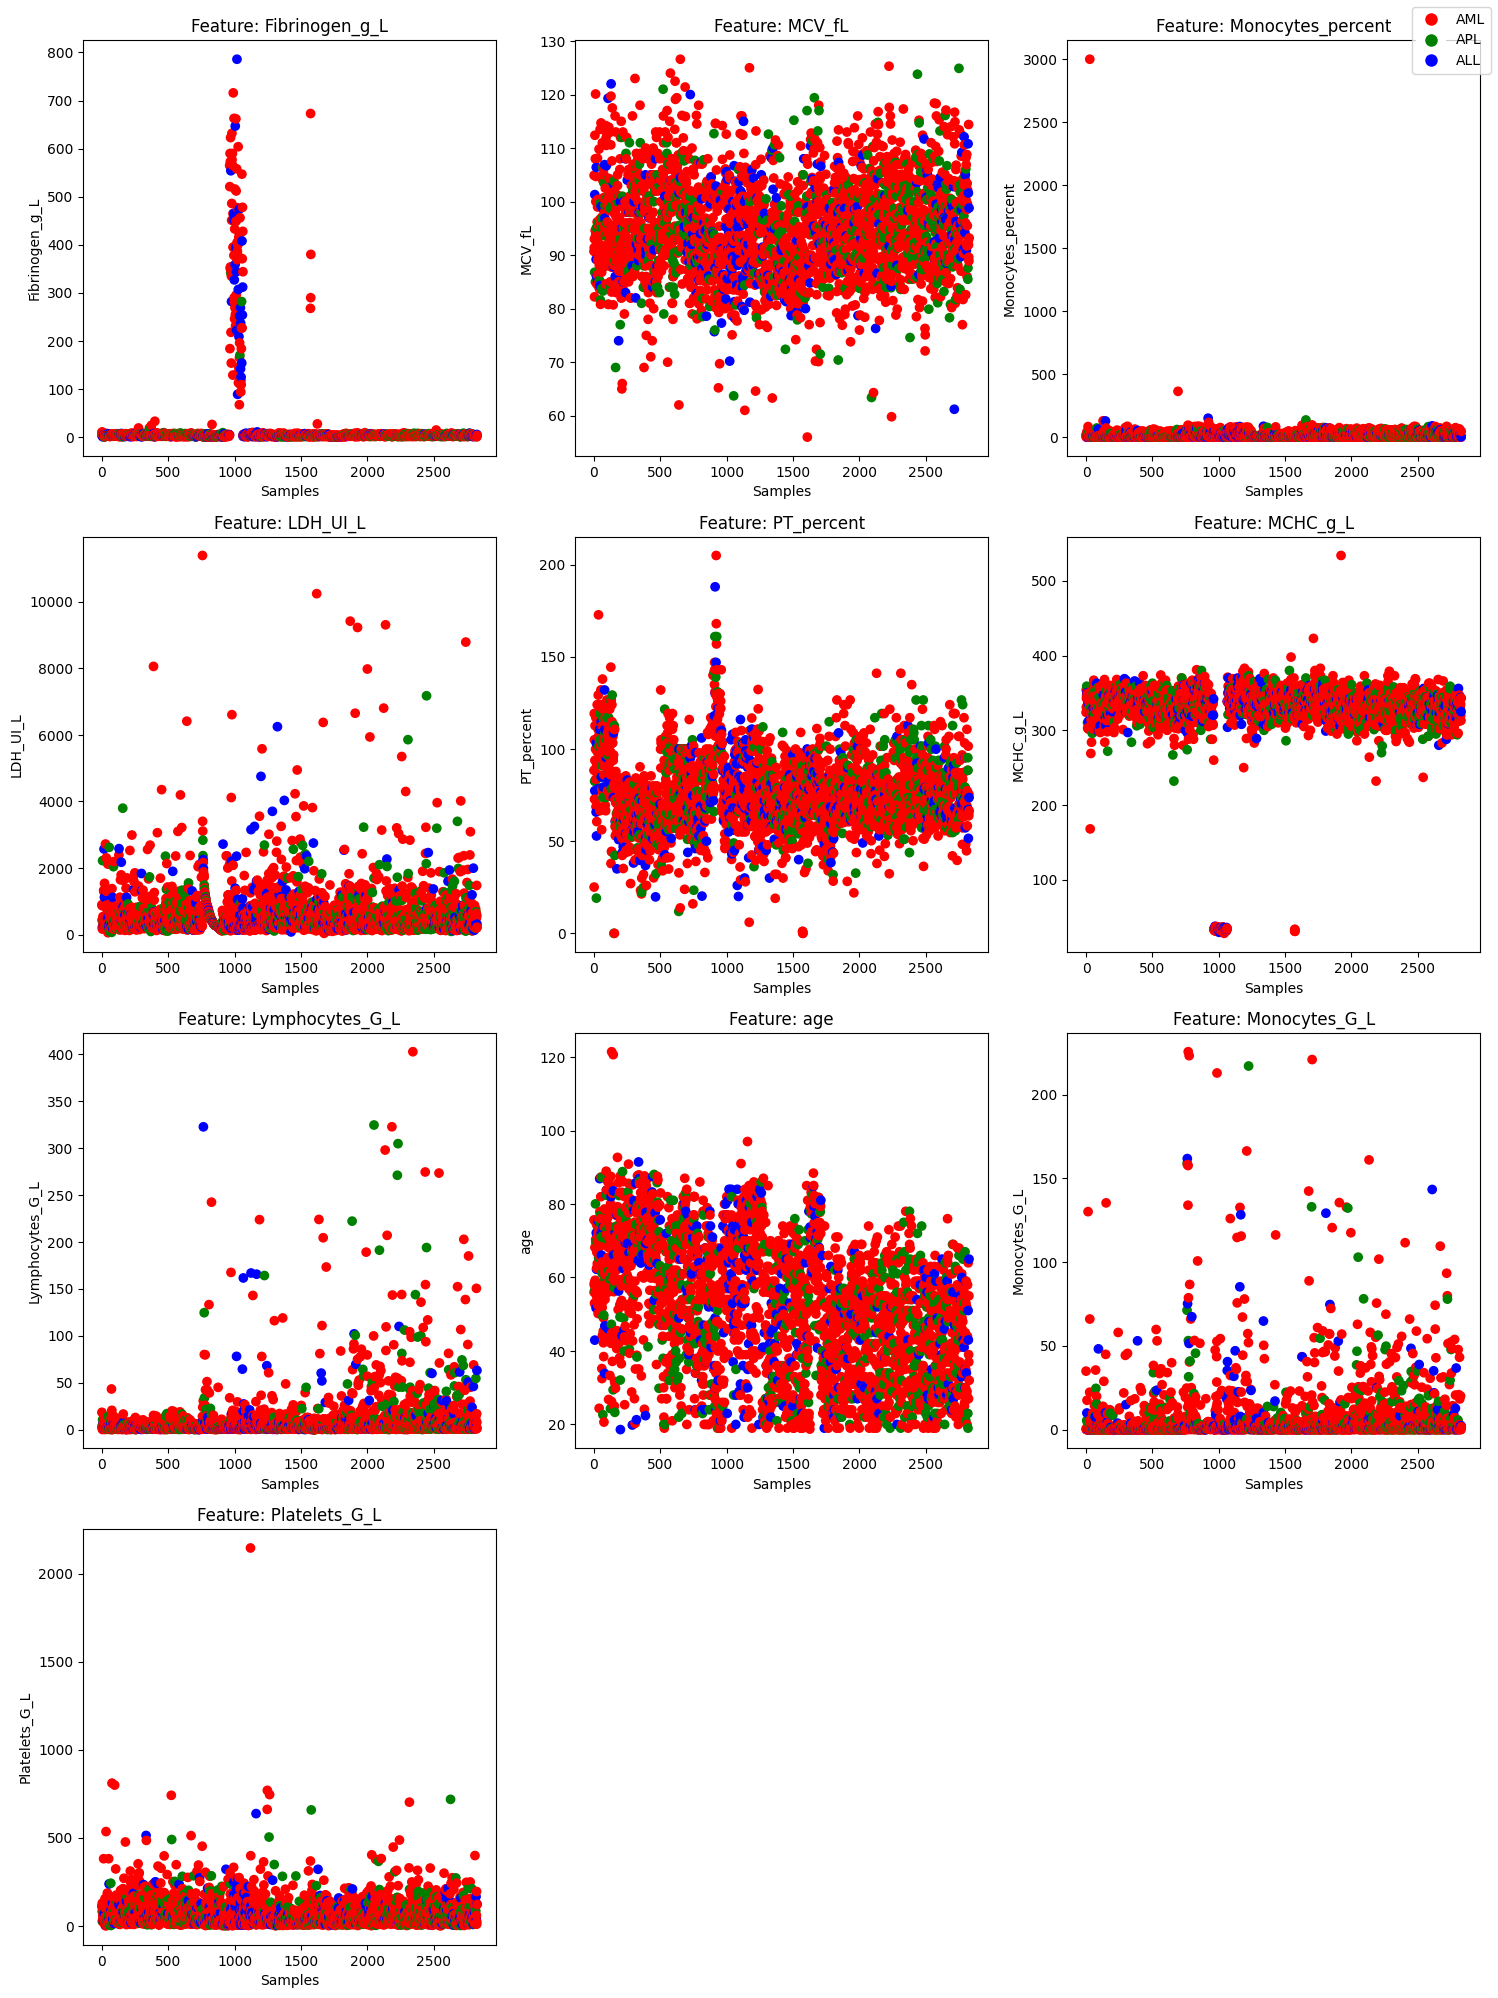

In [5]:
import matplotlib.pyplot as plt
import math

# Extract the features and drop rows with NaN values
features = config['feature_columns']
X = df[features].dropna()

# Align the class labels to match the filtered X rows
y = df['class'].loc[X.index].reset_index(drop=True)  # Ensure consistent indexing
class_colors = {'AML': 'red', 'APL': 'green', 'ALL': 'blue'}
colors = y.map(class_colors)

# Initialize the plot grid
n_features = len(features)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Iterate over each feature and plot it directly
for idx, feature in enumerate(features):
    # Extract data for the current feature and reset index for alignment
    X_feature = X[feature].reset_index(drop=True)
    
    # Match colors with current feature's data
    colors_feature = colors.loc[X_feature.index].reset_index(drop=True)
    
    # Plot the feature values with color mapping based on class
    axes[idx].scatter(range(len(X_feature)), X_feature, c=colors_feature)
    axes[idx].set_title(f'Feature: {feature}')
    axes[idx].set_xlabel('Samples')
    axes[idx].set_ylabel(feature)

# Hide any unused subplots
for i in range(idx + 1, len(axes)):
    axes[i].axis('off')

# Add a legend for the classes
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in class_colors.values()]
labels = class_colors.keys()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

Explained variance for each principal component in AML: [0.95290492 0.01774331]
Explained variance for each principal component in APL: [0.94105419 0.0420286 ]
Explained variance for each principal component in ALL: [0.98803269 0.00598461]


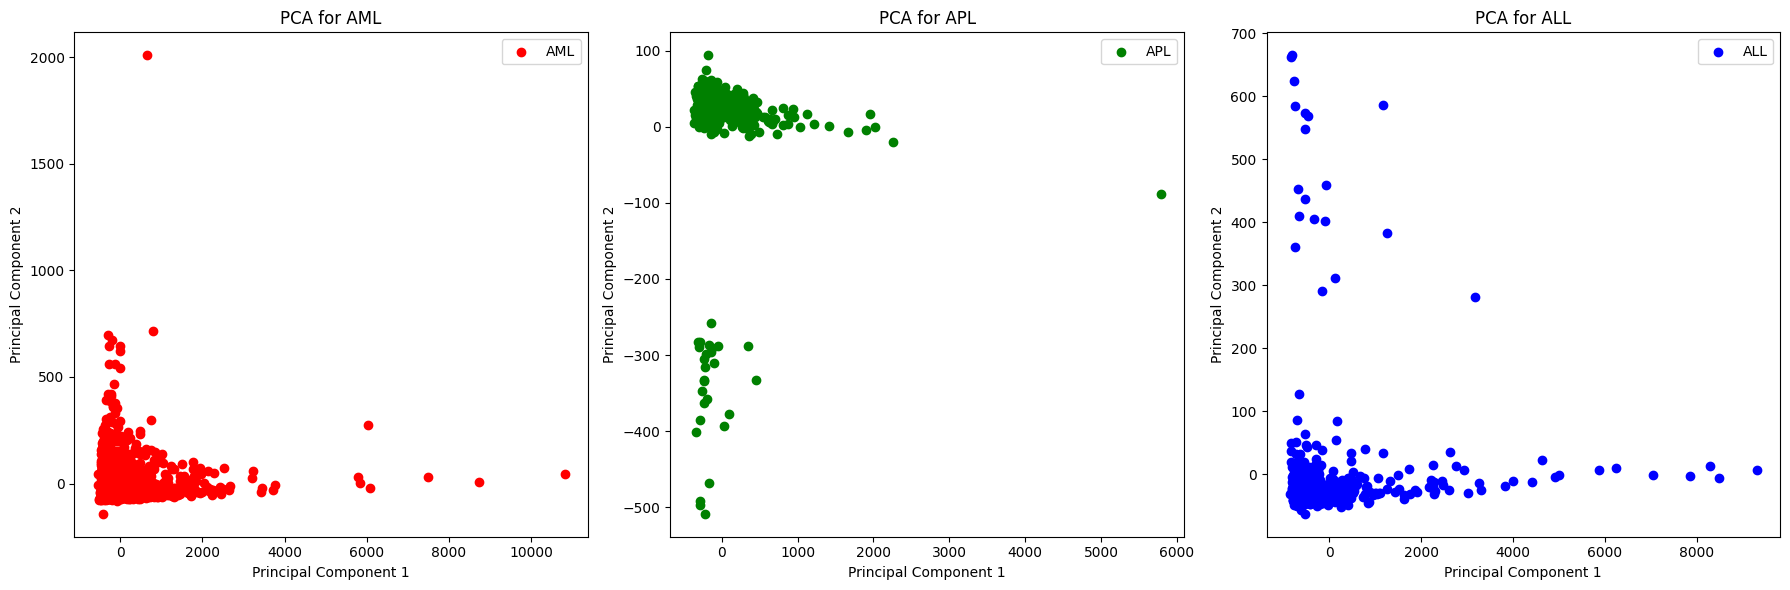

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Extract features and classes, then drop rows with NaN values in either
features = config['feature_columns']
data = df[features + ['class']].dropna()  # Drop rows with NaN in either features or class

X = data[features]
y = data['class']

# Define colors for each class
class_colors = {'AML': 'red', 'APL': 'green', 'ALL': 'blue'}
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Loop through each class, perform PCA, plot, and print explained variance
for i, (class_name, color) in enumerate(class_colors.items()):
    # Filter data for the specific class
    class_data = X[y == class_name]

    # Apply PCA on the data for the specific class
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(class_data)
    
    # Print the explained variance for each component of the class
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance for each principal component in {class_name}: {explained_variance}")

    # Plot the PCA result for the specific class
    axs[i].scatter(pca_result[:, 0], pca_result[:, 1], c=color, label=class_name)
    axs[i].set_title(f'PCA for {class_name}')
    axs[i].set_xlabel('Principal Component 1')
    axs[i].set_ylabel('Principal Component 2')
    axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()